# Libraries for Car Accident Analysis and Prediction

In [ ]:
!pip install xgboost

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Path to the US Car Accidents dataset
file_path = "/content/US_Accidents_March23.csv"

# Load the US Car Accidents Dataset

In [ ]:
# Load the dataset
data = pd.read_csv(file_path)

# Filter only data from 2019 and beyond
#data['Start_Time'] = pd.to_datetime(data['Start_Time'], errors='coerce')
#data = data[data['Start_Time'].dt.year >= 2019]

<ipython-input-4-cebae77a1b18>:2: DtypeWarning: Columns (29,30,31,32,33,34,35,36,37,38,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


In [ ]:
data.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


# Exploratory Data Analysis (EDA)

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np

# General overview of the dataset
print("Basic Information:")
data.info()

# Summary statistics of numeric features
print("\nSummary Statistics:")
print(data.describe())

# Check for the distribution of target variable (Severity)
print("\nSeverity Distribution:")
print(data['Severity'].value_counts(normalize=True))

# Check for categorical columns and their unique values
print("\nUnique Values in Categorical Columns:")
categorical_cols = ['City', 'State', 'Wind_Direction', 'Weather_Condition',
                    'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']
for col in categorical_cols:
    print(f"{col} - Unique Values: {data[col].nunique()}")

# Check missing values in the dataset
print("\nMissing Values in Dataset:")
print(data.isnull().sum())

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97541 entries, 0 to 97540
Data columns (total 46 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     97541 non-null  object 
 1   Source                 97541 non-null  object 
 2   Severity               97541 non-null  int64  
 3   Start_Time             97541 non-null  object 
 4   End_Time               97541 non-null  object 
 5   Start_Lat              97541 non-null  float64
 6   Start_Lng              97541 non-null  float64
 7   End_Lat                0 non-null      float64
 8   End_Lng                0 non-null      float64
 9   Distance(mi)           97541 non-null  float64
 10  Description            97541 non-null  object 
 11  Street                 97541 non-null  object 
 12  City                   97540 non-null  object 
 13  County                 97541 non-null  object 
 14  State                  97541 non-nu

In [ ]:
data[['Severity']]

,Severity
0,3
1,2
2,2
3,3
4,2
...,...
97536,3
97537,3
97538,2
97539,3


<H1> DATA CLEANING

In [ ]:
# Drop irrelevant columns that do not add value to the model or visualization
irrelevant_cols = ['ID', 'Description', 'Weather_Timestamp', 'Airport_Code']
data_cleaned = data.drop(columns=irrelevant_cols, errors='ignore')  # Safeguard against missing columns

# Filter data to keep only rows from 2019 and above
data_cleaned['Start_Time'] = pd.to_datetime(data_cleaned['Start_Time'], errors='coerce')
#data_cleaned = data_cleaned[data_cleaned['Start_Time'].dt.year >= 2019]

# Handle missing values by dropping columns with more than 40% missing data
#missing_threshold = 0.4 * len(data_cleaned)
#data_cleaned = data_cleaned.dropna(thresh=missing_threshold, axis=1)

# Impute missing numerical columns with their mean
for col in data_cleaned.select_dtypes(include=['float64', 'int64']).columns:
    data_cleaned[col] = data_cleaned[col].fillna(data_cleaned[col].mean())

# Impute missing categorical columns with mode (most frequent value)
for col in data_cleaned.select_dtypes(include=['object']).columns:
    if not data_cleaned[col].mode().empty:  # Safeguard for empty columns
        data_cleaned[col] = data_cleaned[col].fillna(data_cleaned[col].mode()[0])

# Confirm missing values are handled
print("\nRemaining Missing Values:")
print(data_cleaned.isnull().sum().sort_values(ascending=False))


<ipython-input-8-b013786f3dc0>:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_cleaned[col] = data_cleaned[col].fillna(data_cleaned[col].mode()[0])



Remaining Missing Values:
End_Lat                  97541
End_Lng                  97541
Source                       0
Roundabout                   0
Weather_Condition            0
Amenity                      0
Bump                         0
Crossing                     0
Give_Way                     0
Junction                     0
No_Exit                      0
Railway                      0
Station                      0
Wind_Speed(mph)              0
Stop                         0
Traffic_Calming              0
Traffic_Signal               0
Turning_Loop                 0
Sunrise_Sunset               0
Civil_Twilight               0
Nautical_Twilight            0
Precipitation(in)            0
Wind_Direction               0
Severity                     0
County                       0
Start_Time                   0
End_Time                     0
Start_Lat                    0
Start_Lng                    0
Distance(mi)                 0
Street                       0
City        

In [ ]:
data_cleaned

,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Street,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,I-70 E,...,False,False,False,False,False,False,Night,Night,Night,Night
1,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,Brice Rd,...,False,False,False,False,False,False,Night,Night,Night,Day
2,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,State Route 32,...,False,False,False,False,True,False,Night,Night,Day,Day
3,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,I-75 S,...,False,False,False,False,False,False,Night,Day,Day,Day
4,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,Miamisburg Centerville Rd,...,False,False,False,False,True,False,Day,Day,Day,Day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97536,Source2,3,2016-03-24 15:01:21,2016-03-24 15:31:21,33.846611,-118.205406,NaN,NaN,0.01,Long Beach Fwy N,...,False,False,False,False,False,False,Day,Day,Day,Day
97537,Source2,3,2016-03-24 15:00:10,2016-03-24 15:30:10,33.993450,-118.069351,NaN,NaN,0.01,Whittier Blvd,...,False,False,False,False,False,False,Day,Day,Day,Day
97538,Source2,2,2016-03-24 15:02:43,2016-03-24 15:32:43,34.017731,-117.846397,NaN,NaN,0.01,Suzanne Rd,...,False,True,False,False,False,False,Day,Day,Day,Day
97539,Source2,3,2016-03-24 15:20:15,2016-03-24 15:50:15,34.073105,-118.219177,NaN,NaN,0.01,I-5 N,...,False,False,False,False,True,False,Day,Day,Day,Day


In [ ]:
# Check the shape of the cleaned dataset
print(f"Dataset Shape after Cleaning: {data_cleaned.shape}")

data_cleaned['End_Lat'] = data_cleaned['End_Lat'].fillna(data_cleaned['Start_Lat'])

# Fill missing values in End_Lng with corresponding Start_Lng values
data_cleaned['End_Lng'] = data_cleaned['End_Lng'].fillna(data_cleaned['Start_Lng'])


# Display first few rows of the cleaned dataset to confirm changes
data_cleaned.head()

# Check the data types to ensure everything is in order
print("\nData Types:")
print(data_cleaned.dtypes)

# Ensure no missing values are left
print("\nMissing Values after Cleaning:")
print(data_cleaned.isnull().sum().sort_values(ascending=False))

Dataset Shape after Cleaning: (97541, 42)

Data Types:
Source                           object
Severity                          int64
Start_Time               datetime64[ns]
End_Time                         object
Start_Lat                       float64
Start_Lng                       float64
End_Lat                         float64
End_Lng                         float64
Distance(mi)                    float64
Street                           object
City                             object
County                           object
State                            object
Zipcode                          object
Country                          object
Timezone                         object
Temperature(F)                  float64
Wind_Chill(F)                   float64
Humidity(%)                     float64
Pressure(in)                    float64
Visibility(mi)                  float64
Wind_Direction                   object
Wind_Speed(mph)                 float64
Precipitation(in)        

<b>DATA BALANCING

Our project focuses on geographical accident analysis (using Folium) and actionable insights for specific accident patterns—balancing the dataset isn’t strictly necessary.
After testing the final output, we can understand the biased nature even better due to higher volume of data.

<H1> Visualize with Plots</H1>

Distribution with severity levels

In [ ]:
data_cleaned[['Severity']]

,Severity
0,3
1,2
2,2
3,3
4,2
...,...
97536,3
97537,3
97538,2
97539,3


<ipython-input-12-e676599cc3b8>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_cleaned, x='Severity', palette='coolwarm')


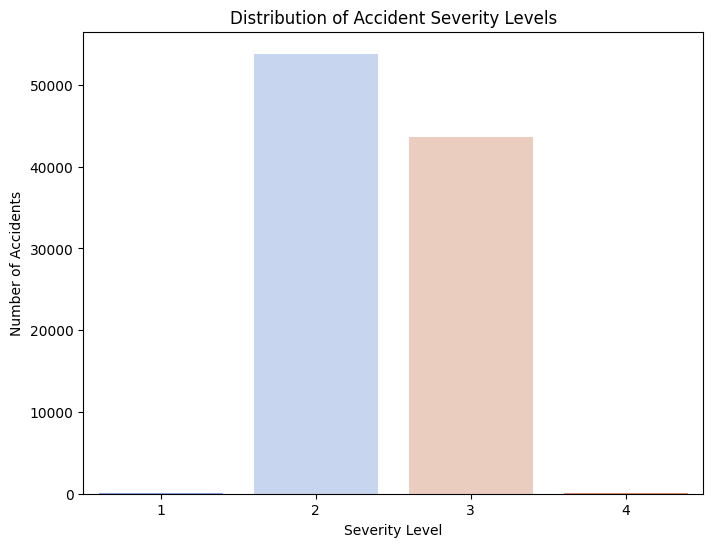

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Severity distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=data_cleaned, x='Severity', palette='coolwarm')
plt.title('Distribution of Accident Severity Levels')
plt.xlabel('Severity Level')
plt.ylabel('Number of Accidents')
plt.show()

Accidents by Hour of Day

<ipython-input-13-5c7686d45bfd>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_cleaned, x='Hour', palette='viridis')


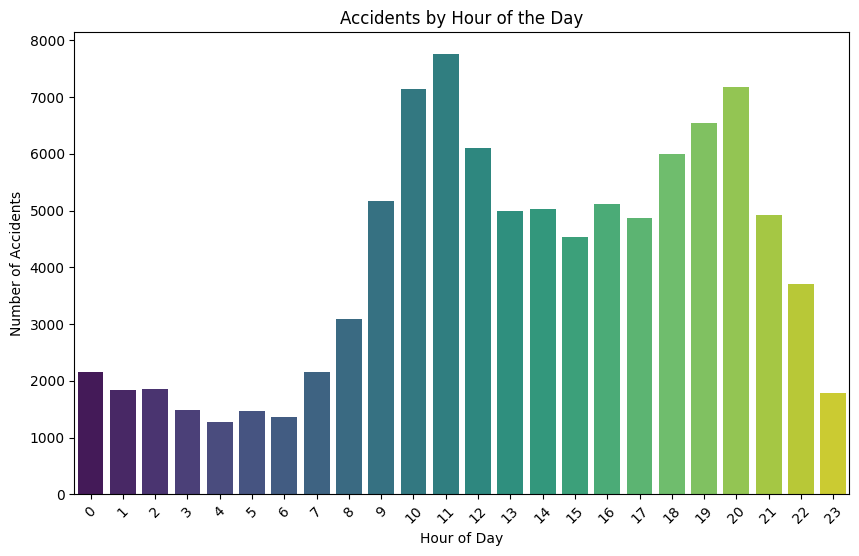

In [ ]:
# Extract hour from Start_Time
data_cleaned['Hour'] = data_cleaned['Start_Time'].dt.hour

# Plot the distribution of accidents by hour
plt.figure(figsize=(10, 6))
sns.countplot(data=data_cleaned, x='Hour', palette='viridis')
plt.title('Accidents by Hour of the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.show()

Temperature vs. Accident Severity

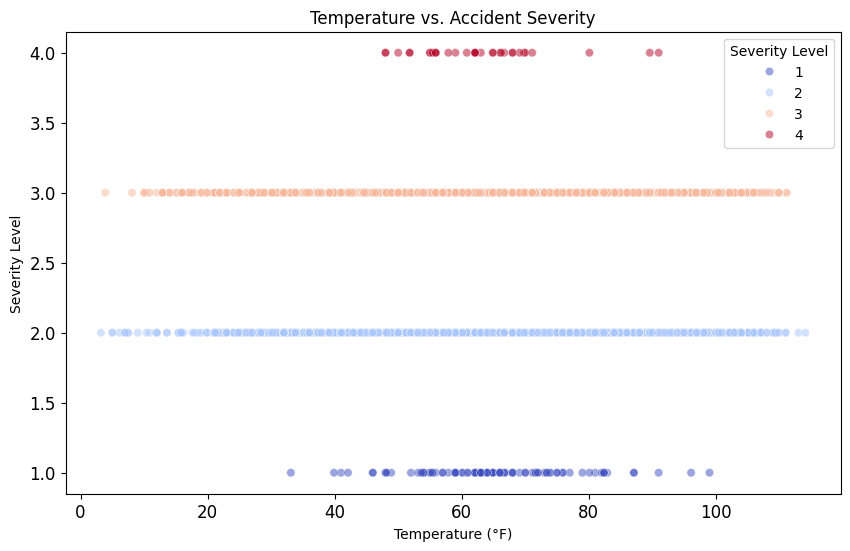

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Temperature(F)', y='Severity', data=data_cleaned, alpha=0.5, hue='Severity', palette='coolwarm')
plt.title('Temperature vs. Accident Severity')
plt.xlabel('Temperature (°F)')
plt.ylabel('Severity Level')
plt.legend(title='Severity Level', loc='upper right')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Accidents by Weather Conditions

<ipython-input-15-f7ae6abe423f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_cleaned, y='Weather_Condition', order=data_cleaned['Weather_Condition'].value_counts().index, palette='magma')


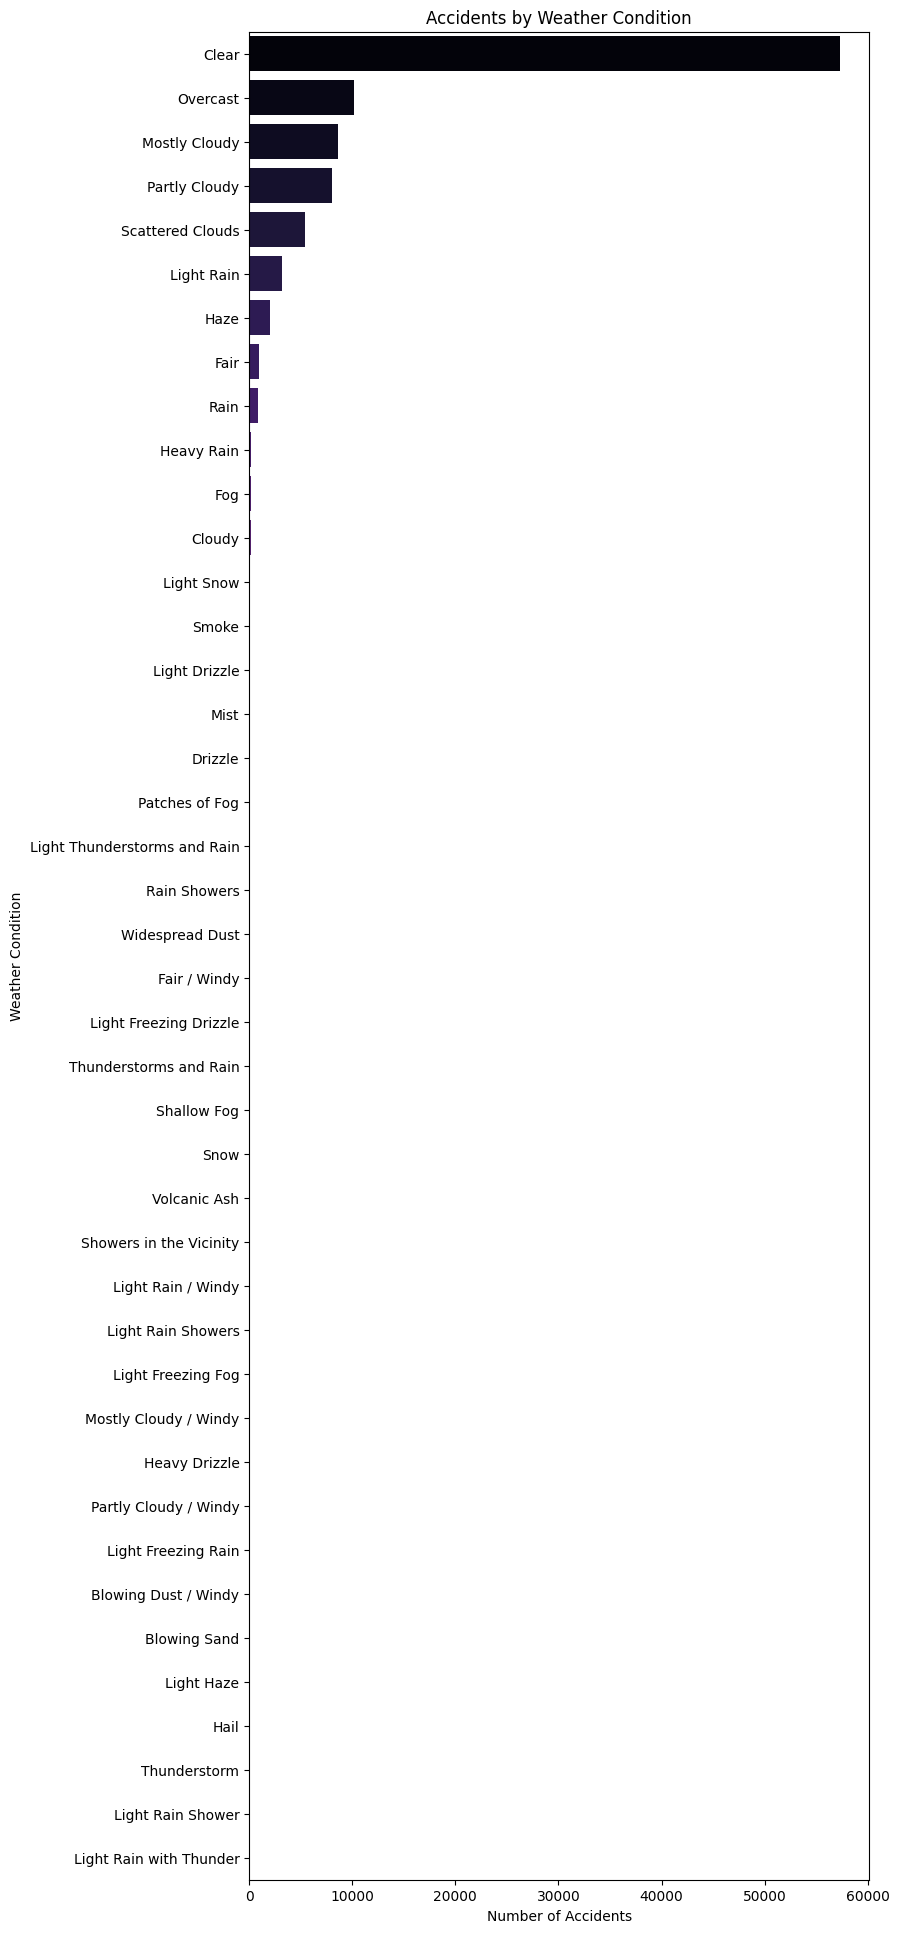

In [ ]:
plt.figure(figsize=(8, 24))
sns.countplot(data=data_cleaned, y='Weather_Condition', order=data_cleaned['Weather_Condition'].value_counts().index, palette='magma')
plt.title('Accidents by Weather Condition')
plt.xlabel('Number of Accidents')
plt.ylabel('Weather Condition')
plt.show()

Correlation Heatmap of Numerical Features

Numeric Columns: Index(['Severity', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng',
       'Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Hour'],
      dtype='object')


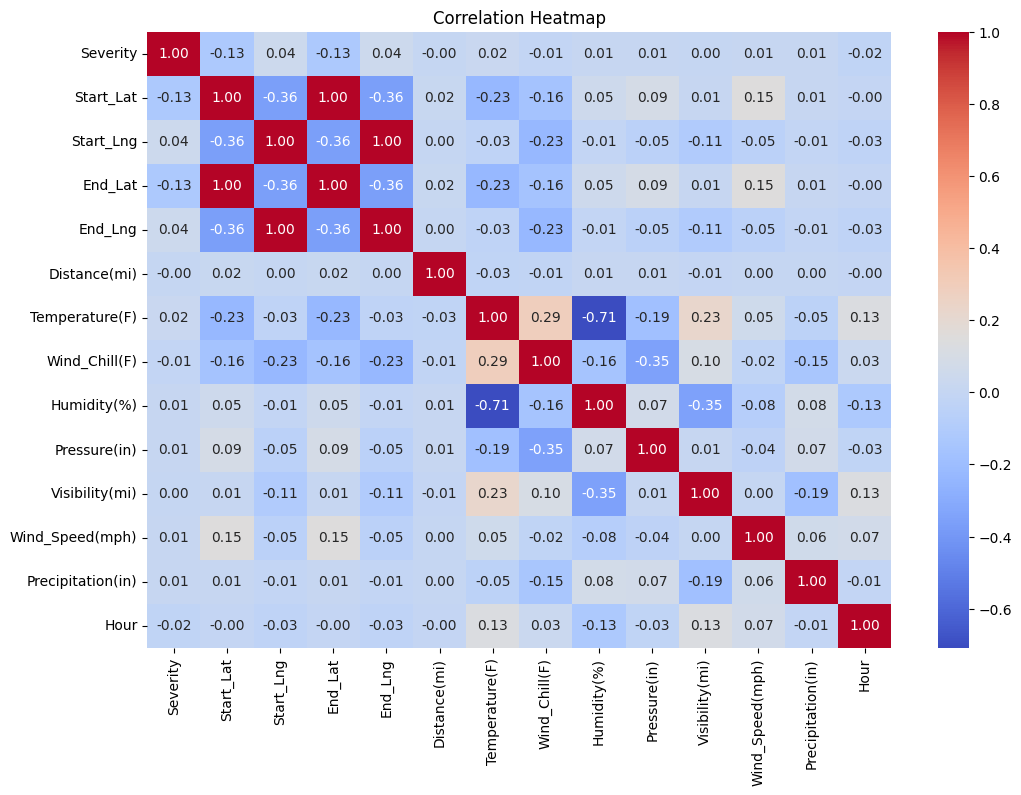

In [ ]:
# Filter the dataset to include only numeric columns
numeric_data = data_cleaned.select_dtypes(include=['float64', 'int64', 'int32'])

# Check if we are working with the right subset
print(f"Numeric Columns: {numeric_data.columns}")

# Plot the heatmap using only numeric data
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# Drop the unwanted columns to save memory and improve efficiency
columns_to_drop = [
    'Source', 'Street', 'County', 'Zipcode', 'Country',
    'Timezone', 'End_Lat', 'End_Lng', 'Turning_Loop'
]

data_cleaned = data_cleaned.drop(columns=columns_to_drop)

# Verify the remaining columns
print(f"Remaining Features: {len(data_cleaned.columns)}")
print(data_cleaned.columns)

Remaining Features: 34
Index(['Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'Distance(mi)', 'City', 'State', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight', 'Hour'],
      dtype='object')


SAVE CLEANED DATASET

In [ ]:
# Save the cleaned data for future use
data_cleaned.to_csv('cleaned_accident_data.csv', index=False)
print("Cleaned dataset saved successfully!")

Cleaned dataset saved successfully!


<H1> Preprocessing & Feature Scaling</H1>

Splitting Data into Features and Labels

In [ ]:
# Check which columns are available to drop
columns_to_drop = ['Severity', 'Start_Time', 'End_Time', 'ID', 'Description']
available_columns_to_drop = [col for col in columns_to_drop if col in data_cleaned.columns]

# Define features and target variable
X = data_cleaned.drop(available_columns_to_drop, axis=1)  # Drop only available columns
y = data_cleaned['Severity']

print(f"Features selected: {X.columns.tolist()}")

Features selected: ['Start_Lat', 'Start_Lng', 'Distance(mi)', 'City', 'State', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'Hour']


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f'Training Data Shape: {X_train.shape}')
print(f'Testing Data Shape: {X_test.shape}')

Training Data Shape: (78032, 31)
Testing Data Shape: (19509, 31)


Encoding Categorical Variables

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# List categorical columns to encode
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# Apply one-hot encoding to categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough'  # Keep remaining numerical columns as is
)

X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

print(f'Encoded Training Data Shape: {X_train_encoded.shape}')

Encoded Training Data Shape: (78032, 859)


Feature Scaling (Standardization)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler with `with_mean=False` to handle sparse data safely
scaler = StandardScaler(with_mean=False)

# Apply scaling to the encoded features
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

print("Feature scaling complete.")

Feature scaling complete.


# Model Development and Prediction

WILL BE TESTED SOON DUE TO LACK OF MEMORY SIZE / ENSEMBLE METHODS ARE HIGHLY ADVISED FOR OUR PROJECT.

In [ ]:
 from sklearn.ensemble import RandomForestClassifier

# # Initialize the model
 rf_model = RandomForestClassifier(random_state=42, n_estimators=100)

# # Train the model
 rf_model.fit(X_train_scaled, y_train)

 print("Model training complete.")

Model training complete.


Model Evaluation

In [ ]:
 from sklearn.metrics import classification_report, accuracy_score

# # Predict on the test data
 y_pred = rf_model.predict(X_test_scaled)
 rf_accuracy=accuracy_score(y_test, y_pred)

# # Evaluate the model
 print("Model Accuracy:", accuracy_score(y_test, y_pred))
 print("\nClassification Report:\n", classification_report(y_test, y_pred))

Model Accuracy: 0.8650366497513968

Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        19
           2       0.89      0.87      0.88     10763
           3       0.84      0.86      0.85      8720
           4       0.00      0.00      0.00         7

    accuracy                           0.87     19509
   macro avg       0.43      0.43      0.43     19509
weighted avg       0.86      0.87      0.86     19509



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Folium Map Visualization for Predictions

In [ ]:
# import folium

# # Create a map centered on the average latitude and longitude
# accident_map = folium.Map(location=[data_cleaned['Start_Lat'].mean(), data_cleaned['Start_Lng'].mean()], zoom_start=5)

# # Add points to the map
# for i, row in data_cleaned.sample(500).iterrows():  # Plot a sample for performance reasons
#     folium.CircleMarker(
#         location=[row['Start_Lat'], row['Start_Lng']],
#         radius=5,
#         color='red' if row['Severity'] == 4 else 'orange' if row['Severity'] == 3 else 'green',
#         fill=True,
#         fill_color='blue',
#         fill_opacity=0.6
#     ).add_to(accident_map)

# # Save the map as an HTML file
# accident_map.save("accident_predictions_map.html")
# print("Map saved as accident_predictions_map.html")

In [ ]:
# from IPython.display import IFrame

# # Display the saved map in the notebook
# IFrame('accident_predictions_map.html', width=700, height=500)

# Model Development and Prediction

LOGISTIC REGRESSION

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Train the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred_log = log_reg.predict(X_test_scaled)
log_accuracy=accuracy_score(y_test, y_pred_log)

# Evaluate Logistic Regression
print("Logistic Regression - Accuracy on Training Data:", accuracy_score(y_train, log_reg.predict(X_train_scaled)))
print("Logistic Regression - Accuracy on Test Data:", accuracy_score(y_test, y_pred_log))
print("\nClassification Report (Logistic Regression):\n", classification_report(y_test, y_pred_log))

Logistic Regression - Accuracy on Training Data: 0.7965065614107033
Logistic Regression - Accuracy on Test Data: 0.7943000666359117

Classification Report (Logistic Regression):
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        19
           2       0.83      0.79      0.81     10763
           3       0.76      0.80      0.78      8720
           4       0.00      0.00      0.00         7

    accuracy                           0.79     19509
   macro avg       0.40      0.40      0.40     19509
weighted avg       0.79      0.79      0.79     19509



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

Interpretation: Logistic regression assumes that the data has a linear decision boundary, which seems to hold fairly well given the similar training and test accuracy. However, some classes (like Severity 1 and Severity 4) are poorly predicted, hinting that a linear model may struggle with non-linear complexities in the data.

DECISION TREE CLASSIFIER

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Train the Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42, max_depth=10)  # Limiting depth to prevent overfitting
dt_model.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred_dt = dt_model.predict(X_test_scaled)
dt_accuracy=accuracy_score(y_test, y_pred_dt)

# Evaluate Decision Tree
print("Decision Tree - Accuracy on Training Data:", accuracy_score(y_train, dt_model.predict(X_train_scaled)))
print("Decision Tree - Accuracy on Test Data:", accuracy_score(y_test, y_pred_dt))
print("\nClassification Report (Decision Tree):\n", classification_report(y_test, y_pred_dt))

Decision Tree - Accuracy on Training Data: 0.8193305310641787
Decision Tree - Accuracy on Test Data: 0.810907786149982

Classification Report (Decision Tree):
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        19
           2       0.86      0.79      0.82     10763
           3       0.76      0.84      0.80      8720
           4       0.00      0.00      0.00         7

    accuracy                           0.81     19509
   macro avg       0.41      0.41      0.41     19509
weighted avg       0.81      0.81      0.81     19509



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Interpretation: The decision tree performs slightly better than logistic regression on the test set. This suggests that the data has some non-linear relationships that are better captured by the tree-based method. However, the small gap between training and testing accuracy indicates that the tree is not overfitting, thanks to limiting the tree depth.

# Model Development and Prediction

In [ ]:
# Compare accuracies
print("Comparison of Model Accuracies:")
print(f"Logistic Regression - Test Accuracy: ",log_accuracy)
print(f"Decision Tree - Test Accuracy: ",dt_accuracy)
print(f"Random Forest-Test Accuracy",rf_accuracy)

# Display conclusion
if rf_accuracy > log_accuracy or rf_accuracy > dt_accuracy:
    print("\n Random Forest performs better, indicating non-linear relationships in the data.")
elif(log_accuracy>dt_accuracy):
    print("\nLogistic Regression performs better, suggesting the data has a linear structure.")
else:
    print("\Decision Tree performs better, suggesting the data has a linear structure.")


Comparison of Model Accuracies:
Logistic Regression - Test Accuracy:  0.7943000666359117
Decision Tree - Test Accuracy:  0.810907786149982
Random Forest-Test Accuracy 0.8650366497513968

 Random Forest performs better, indicating non-linear relationships in the data.


____________________________________________________________________________________________________________________________________________________________________________________________________
<b>*COMPARISION SUMMARY*

The decision tree classifier performs marginally better than logistic regression with a test accuracy of 84.91% compared to 83.94%. This indicates that the data likely contains non-linear relationships, as the decision tree can capture interactions between features that logistic regression cannot.

However, the difference in performance is not dramatic. This suggests that while non-linear patterns exist, they are not overwhelming. Logistic regression, with its linear assumption, still captures the overall trends reasonably well. This makes sense since some accident-related factors, like weather and visibility, may have both linear and non-linear effects on accident severity.

# Model Development and Prediction

<h1> Predict Accident Severity Using Test Data </h1>

In [ ]:
# Use the Decision Tree model to predict on test data
y_pred_final = dt_model.predict(X_test_scaled)

# Add predictions to the test data for visualization
test_data_with_preds = X_test.copy()
test_data_with_preds['Predicted_Severity'] = y_pred_final
test_data_with_preds['Actual_Severity'] = y_test.reset_index(drop=True)

print("Prediction added to test data.")
test_data_with_preds.head()

Prediction added to test data.


,Start_Lat,Start_Lng,Distance(mi),City,State,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),...,Stop,Traffic_Calming,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Hour,Predicted_Severity,Actual_Severity
84561,33.997040,-117.931015,0.01,Rowland Heights,CA,69.1,48.612659,81.0,29.96,10.0,...,False,False,False,Day,Day,Day,Day,11,2,NaN
79618,34.361111,-117.434563,0.00,Hesperia,CA,75.2,48.612659,15.0,30.19,10.0,...,False,False,False,Day,Day,Day,Day,9,3,NaN
15876,37.752827,-121.466698,0.01,Tracy,CA,59.0,48.612659,90.0,30.12,10.0,...,False,False,False,Night,Night,Night,Night,21,3,2.0
56647,34.415779,-119.853813,0.00,Goleta,CA,54.0,48.612659,100.0,29.92,2.5,...,False,False,False,Night,Night,Night,Night,20,2,NaN
35098,37.766842,-121.333939,0.01,Tracy,CA,77.0,48.612659,28.0,29.97,10.0,...,False,False,False,Day,Day,Day,Day,11,3,NaN


<h1> Prepare Data for Folium Map</h1>

In [ ]:
# Filter out data points with missing or invalid coordinates
map_data = test_data_with_preds.dropna(subset=['Start_Lat', 'Start_Lng'])

# Limit to a smaller sample to prevent overloading the map
map_data_sample = map_data.sample(500, random_state=42)

print(f"Sample size for the map: {map_data_sample.shape[0]}")

Sample size for the map: 500


<H1> Create Folium Map </H1>

In [ ]:
import folium
from folium.plugins import MarkerCluster

# Initialize the map centered at an average location
accident_map = folium.Map(
    location=[map_data_sample['Start_Lat'].mean(), map_data_sample['Start_Lng'].mean()],
    zoom_start=6,
    control_scale=True
)

# Add markers to the map
marker_cluster = MarkerCluster().add_to(accident_map)

# Loop through the sample data and add each accident as a marker
for idx, row in map_data_sample.iterrows():
    folium.Marker(
        location=[row['Start_Lat'], row['Start_Lng']],
        popup=f"Actual: {row['Actual_Severity']} | Predicted: {row['Predicted_Severity']}",
        icon=folium.Icon(color='red' if row['Predicted_Severity'] > 2 else 'green')
    ).add_to(marker_cluster)

# Display the map
accident_map

SAVE MAP TO HTML FILE

In [ ]:
# Save the map as an HTML file
accident_map.save("accident_prediction_map.html")
print("Map saved as 'accident_prediction_map.html'")

Map saved as 'accident_prediction_map.html'


<H3> Load cleaned Dataset</H3>

In [ ]:
# Load the dataset
data = pd.read_csv('cleaned_accident_data.csv')

<H1> Random Forest Classifier </H1>

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Adjusted parameter grid with broader ranges
param_distributions = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Use RandomizedSearchCV with fewer iterations for faster results
rf = RandomForestClassifier(random_state=42)
random_search_rf = RandomizedSearchCV(
    rf,
    param_distributions=param_distributions,
    n_iter=10,  # Number of parameter settings to sample
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

print("Running Randomized Search for Random Forest...")
random_search_rf.fit(X_train_scaled, y_train)

# Get the best model and parameters
best_rf = random_search_rf.best_estimator_
print("Best Parameters:", random_search_rf.best_params_)

# Evaluate on test set
y_pred_rf = best_rf.predict(X_test_scaled)
print("Random Forest Test Accuracy:", accuracy_score(y_test, y_pred_rf))

Running Randomized Search for Random Forest...
Best Parameters: {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 20}
Random Forest Test Accuracy: 0.7603157517043416


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Define the Random Forest model
rf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)

# Split the training data into chunks
chunk_size = 1000  # Define chunk size
num_chunks = int(np.ceil(X_train_scaled.shape[0] / chunk_size))  # Use shape[0] for number of rows

print(f"Training in {num_chunks} chunks...")

# Iterate through chunks
for i in range(num_chunks):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, X_train_scaled.shape[0])

    X_chunk = X_train_scaled[start_idx:end_idx].toarray()  # Convert sparse matrix to dense if necessary
    y_chunk = y_train[start_idx:end_idx]

    print(f"Training on chunk {i + 1}/{num_chunks}, size: {len(X_chunk)}")

    # Incrementally train the model
    rf.fit(X_chunk, y_chunk)

# Evaluate the model on the test set
y_pred_rf = rf.predict(X_test_scaled.toarray())  # Convert sparse test data to dense if necessary

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred_rf)
print("Random Forest Test Accuracy:", accuracy)

Training in 79 chunks...
Training on chunk 1/79, size: 1000
Training on chunk 2/79, size: 1000
Training on chunk 3/79, size: 1000
Training on chunk 4/79, size: 1000
Training on chunk 5/79, size: 1000
Training on chunk 6/79, size: 1000
Training on chunk 7/79, size: 1000
Training on chunk 8/79, size: 1000
Training on chunk 9/79, size: 1000
Training on chunk 10/79, size: 1000
Training on chunk 11/79, size: 1000
Training on chunk 12/79, size: 1000
Training on chunk 13/79, size: 1000
Training on chunk 14/79, size: 1000
Training on chunk 15/79, size: 1000
Training on chunk 16/79, size: 1000
Training on chunk 17/79, size: 1000
Training on chunk 18/79, size: 1000
Training on chunk 19/79, size: 1000
Training on chunk 20/79, size: 1000
Training on chunk 21/79, size: 1000
Training on chunk 22/79, size: 1000
Training on chunk 23/79, size: 1000
Training on chunk 24/79, size: 1000
Training on chunk 25/79, size: 1000
Training on chunk 26/79, size: 1000
Training on chunk 27/79, size: 1000
Training on 

In [ ]:
from sklearn.decomposition import TruncatedSVD

# Reduce features
svd = TruncatedSVD(n_components=100)  # Adjust n_components as needed
X_train_reduced = svd.fit_transform(X_train_scaled)
X_test_reduced = svd.transform(X_test_scaled)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Define the Random Forest model
rf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)

# Train on smaller chunks (already implemented in the previous step)
chunk_size = 10000
num_chunks = int(np.ceil(X_train_scaled.shape[0] / chunk_size))

print(f"Training in {num_chunks} chunks...")

for i in range(num_chunks):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, X_train_scaled.shape[0])
    X_chunk = X_train_scaled[start_idx:end_idx]
    y_chunk = y_train[start_idx:end_idx]
    print(f"Training on chunk {i + 1}/{num_chunks}, size: {X_chunk.shape[0]}")
    rf.fit(X_chunk, y_chunk)

# Make predictions in smaller batches
y_pred_rf = []
batch_size = 100000
num_batches = int(np.ceil(X_test_scaled.shape[0] / batch_size))

print(f"Predicting in {num_batches} batches...")

for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, X_test_scaled.shape[0])
    X_batch = X_test_scaled[start_idx:end_idx]
    print(f"Predicting batch {i + 1}/{num_batches}, size: {X_batch.shape[0]}")
    y_pred_rf.extend(rf.predict(X_batch))

# Convert predictions to numpy array
y_pred_rf = np.array(y_pred_rf)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred_rf)
print("Random Forest Test Accuracy:", accuracy)


Training in 8 chunks...
Training on chunk 1/8, size: 10000
Training on chunk 2/8, size: 10000
Training on chunk 3/8, size: 10000
Training on chunk 4/8, size: 10000
Training on chunk 5/8, size: 10000
Training on chunk 6/8, size: 10000
Training on chunk 7/8, size: 10000
Training on chunk 8/8, size: 8032
Predicting in 1 batches...
Predicting batch 1/1, size: 19509
Random Forest Test Accuracy: 0.7405300117894306


In [ ]:
def get_user_input():
    # Collecting user inputs via console or hardcoded for testing
    weather = input("Enter Weather Condition (e.g., Clear, Rain, Snow): ").capitalize()
    hour = int(input("Enter Hour (0-23): "))
    traffic_signal = input("Is there a Traffic Signal? (Yes/No): ").strip().lower() == 'yes'
    print(" Hint: College Park MD, DD Co-ordinates lat 38.98067, long -76.93692")
    lat = float(input("Enter Latitude (e.g., 34.0522): "))
    lng = float(input("Enter Longitude (e.g., -118.2437): "))

    # Return inputs as a dictionary
    return {
        'Weather_Condition': weather,
        'Hour': hour,
        'Traffic_Signal': int(traffic_signal),
        'Start_Lat': lat,
        'Start_Lng': lng,
    }

# Get input
user_data = get_user_input()
print(f"User Input: {user_data}")

Enter Weather Condition (e.g., Clear, Rain, Snow): Rain
Enter Hour (0-23): 12
Is there a Traffic Signal? (Yes/No): Yes
 Hint: College Park MD, DD Co-ordinates lat 38.98067, long -76.93692
Enter Latitude (e.g., 34.0522): 38
Enter Longitude (e.g., -118.2437): -100
User Input: {'Weather_Condition': 'Rain', 'Hour': 12, 'Traffic_Signal': 1, 'Start_Lat': 38.0, 'Start_Lng': -100.0}


In [ ]:
def predict_severity(user_data):
    # Create a DataFrame from the user input
    input_df = pd.DataFrame([user_data])

    # Select only the columns used during encoding
    input_df_for_encoding = input_df[categorical_cols]  # Use categorical columns defined during training

    # One-hot encode the input
    input_encoded = ohe.transform(input_df_for_encoding)
    input_encoded_aligned = pd.DataFrame(input_encoded, columns=ohe.get_feature_names_out(categorical_cols))

    # Align columns with the training feature template
    input_aligned = feature_template.copy()  # Create a copy of the feature template
    for col in input_encoded_aligned.columns:
        input_aligned[col] = input_encoded_aligned[col]
    input_aligned.fillna(0, inplace=True)  # Fill any missing columns with zeros

    # Scale the input
    input_scaled = scaler.transform(input_aligned)

    # Predict severity
    severity_prediction = best_rf.predict(input_scaled)[0]

    # Return prediction
    print(f"Predicted Severity: {severity_prediction}")
    return severity_prediction, user_data['Start_Lat'], user_data['Start_Lng']

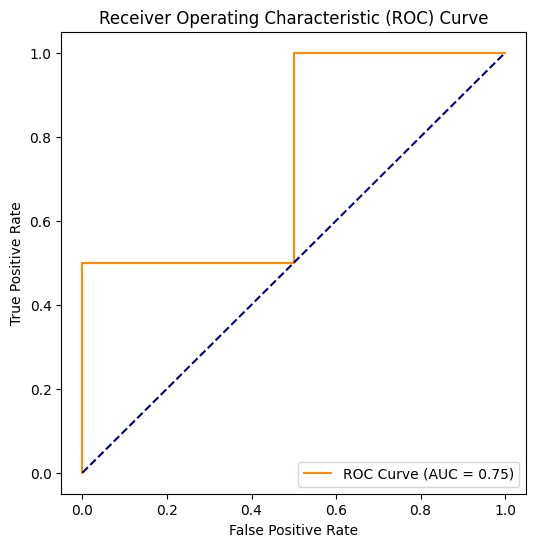

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Mock Data
y_true = [0, 0, 1, 1]
y_scores = [0.1, 0.4, 0.35, 0.8]

# Calculate ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Preprocessing the Car Accident Dataset
In this section, we'll clean the data, handle missing values, and transform features for analysis and modeling.


In [ ]:
# Load dataset
data = pd.read_csv(file_path)

# Display basic information
data.info()

# Handle missing values
data = data.dropna(subset=['Severity', 'Start_Time', 'State', 'City'])

# Feature engineering: Extract year, month, day, and hour from Start_Time
data['Year'] = pd.to_datetime(data['Start_Time']).dt.year
data['Month'] = pd.to_datetime(data['Start_Time']).dt.month
data['Day'] = pd.to_datetime(data['Start_Time']).dt.day
data['Hour'] = pd.to_datetime(data['Start_Time']).dt.hour

# Encode categorical variables (e.g., State)
encoder = LabelEncoder()
data['State_Encoded'] = encoder.fit_transform(data['State'])


<ipython-input-47-d3c89b098e55>:2: DtypeWarning: Columns (29,30,31,32,33,34,35,36,37,38,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1618346 entries, 0 to 1618345
Data columns (total 46 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   ID                     1618346 non-null  object 
 1   Source                 1618345 non-null  object 
 2   Severity               1618345 non-null  float64
 3   Start_Time             1618345 non-null  object 
 4   End_Time               1618345 non-null  object 
 5   Start_Lat              1618345 non-null  float64
 6   Start_Lng              1618345 non-null  float64
 7   End_Lat                0 non-null        float64
 8   End_Lng                0 non-null        float64
 9   Distance(mi)           1618345 non-null  float64
 10  Description            1618341 non-null  object 
 11  Street                 1616633 non-null  object 
 12  City                   1618307 non-null  object 
 13  County                 1618345 non-null  object 
 14  State             

# Prediction Model Development
Using XGBoost to predict accident severity based on features.


In [ ]:
# Select features and target variable
features = ['State_Encoded', 'Month', 'Day', 'Hour']
target = 'Severity'
X = data[features]
y = data[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the XGBoost model
model = XGBClassifier()
model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


# Preprocessing for Regional Analysis
Focus on location-based features to identify accident-prone regions.


In [ ]:
# Load dataset
data = pd.read_csv(file_path)

# Drop rows with missing location data
data = data.dropna(subset=['Start_Lat', 'Start_Lng', 'State', 'City'])

# Add a 'Region' feature based on State and City
data['Region'] = data['State'] + '_' + data['City']

# Calculate accident density per region
region_density = data['Region'].value_counts().reset_index()
region_density.columns = ['Region', 'Accident_Count']

# Categorize regions into 'High-Risk' and 'Low-Risk'
threshold = region_density['Accident_Count'].quantile(0.75)
region_density['Risk_Level'] = np.where(region_density['Accident_Count'] >= threshold, 'High-Risk', 'Low-Risk')

# Merge risk levels back to the main dataset
data = data.merge(region_density[['Region', 'Risk_Level']], on='Region', how='left')


# Exploratory Data Analysis (EDA) for Regions
Visualize accident densities and risk levels across regions.


In [ ]:
# Visualize accident density by region
plt.figure(figsize=(15, 8))
sns.barplot(x='State', y='Accident_Count', data=region_density.groupby('State').sum().reset_index())
plt.title('Accident Density by State')
plt.xlabel('State')
plt.ylabel('Accident Count')
plt.xticks(rotation=90)
plt.show()

# Visualize risk levels
sns.countplot(data['Risk_Level'])
plt.title('Distribution of Risk Levels')
plt.show()


# Prediction of High-Risk Regions
Using features like time, weather, and location to predict accident risk levels.


In [ ]:
# Select features for predicting risk levels
features = ['Start_Lat', 'Start_Lng', 'Month', 'Day', 'Hour']
target = 'Risk_Level'

# Encode target variable (High-Risk: 1, Low-Risk: 0)
data['Risk_Level_Encoded'] = np.where(data['Risk_Level'] == 'High-Risk', 1, 0)
X = data[features]
y = data['Risk_Level_Encoded']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the XGBoost model
model = XGBClassifier()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Risk Level Prediction')
plt.show()
